In [1]:
from torch.utils.data import Dataset
import pyedflib
import numpy as np
import pandas as pd
from scipy.signal import spectrogram, welch
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from chb_utils import parse_summary_file, parse_summary_file_chb24
import os
import random
import hdbscan
import math
import yasa
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay,roc_auc_score, f1_score,classification_report
import matplotlib.pyplot as plt
            
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from hdbscan import flat

sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 12 edf files


In [2]:
class DataWindow:
    def __init__(self, record_id, record_file, start_index, end_index, label, channels,):
        self.record_id = record_id
        self.record_file = record_file
        self.start_index = start_index
        self.end_index = end_index
        self.label = label
        self.channels = channels
        
    def get_data(self):
        with pyedflib.EdfReader(self.record_file) as f:
            labels = f.getSignalLabels()
            
            expected_channels = 23
            actual_channels   = f.signals_in_file
            
            data = []
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            #if len(idxs) != expected_channels: 
            #    raise ValueError(f'{len(idxs)} channels found, expected {expected_channels}.')
            
            size = self.end_index - self.start_index
            data = np.zeros((expected_channels, size))
            for i,j in enumerate(idxs):
                data[i, :] = f.readSignal(j, self.start_index, size)
        return data

In [19]:
class ChbDataset(Dataset):
    def __init__(self, data_dir='./chb-mit-scalp-eeg-database-1.0.0/',
                 seizures_only=True,sample_rate=256,subject='chb01',mode='train',
                 window_length=5, preictal_length=300, sampler='all', welch_features=False,
                 multiclass=True, sliding=False): 
        ### other sampler option is "equal"
        'Initialization'
        self.sample_rate = sample_rate
        self.subject = subject
        self.data_dir = data_dir
        self.window_length = window_length
        self.preictal_length = preictal_length
        self.welch_features = welch_features
        self.multiclass = multiclass
        self.sampler = sampler
        self.mode = mode
        self.record_type = 'RECORDS-WITH-SEIZURES' if seizures_only else 'RECORDS'
        self.records = None
        self.num_channels = 23
        self.sliding = sliding
        self.preictal = []
        self.ictal = []
        self.interictal = []
        self.windows = []
        self.channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                               'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                               'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']

        #self.bands = [0.5,3.5,6.5,9.5,12.5,15.5,18.5,21.5,24.5]
        self.bands = [4,8,13,30,60,90]

        random.seed(1000)
        self.get_records() 
        self.get_labeled_windows()
        self.get_windows_for_epoch()
        
    def get_records(self):
        with open(self.data_dir+self.record_type) as f:
            self.records = f.read().strip().splitlines()
            f.close()
            
        with open(self.data_dir+'RECORDS-WITH-SEIZURES') as f:
            self.labelled = f.read().strip().splitlines()
            f.close()
            
        #filter based on subject
        self.records = [record for record in self.records if self.subject in record]
        
        limit_file = None
        if self.mode == 'train':
            limit_file = 'TRAIN_RECORDS.txt'
        elif self.mode == 'test':
            limit_file = 'TEST_RECORDS.txt'
            
        if limit_file:
            with open(limit_file) as f:
                limit_records = set(f.read().strip().splitlines())
                records = set(self.records)
            self.records = list(records.intersection(limit_records))
        
        for record in self.records:
            f = pyedflib.EdfReader(self.data_dir+ '/'+record)
            labels = f.getSignalLabels()
            idxs = []
            for channel in self.channels:
                if channel in labels:
                    idxs.append(labels.index(channel))
            if len(idxs) != len(self.channels):
                self.records.remove(record)
                print(f"Record {record} removed because it contained {len(idxs)} channels.")
            f.close()
        print(self.records)
    
    def get_labeled_windows(self):
        summary_file = os.path.join(
            self.data_dir,
            self.subject,
            f"{self.subject}-summary.txt")
        if self.subject == 'chb24':
            all_records = parse_summary_file_chb24(summary_file)
        else:
            all_records = parse_summary_file(summary_file)

        for record in all_records:
            #assert len(record.channels) == num_channels, f"Expected {num_channels} channels, found {len(record.channels)}"
            if f"{self.subject}/{record.fileid}" in self.records:
                filename = os.path.join(self.data_dir, self.subject, record.fileid)
                prev_end = 0
                    
                if record.duration is None:
                    duration = self.get_record_duration(filename)
                else:
                    duration = int(record.duration.total_seconds())
                end_of_file = duration * self.sample_rate
                if len(record.seizures) > 0:
                    seizures = []
                    for seizure in record.seizures:
                        if self.multiclass:
                            preictal_start = max(self.sample_rate * (seizure.start_time - self.preictal_length), 0)
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, preictal_start, 0,self.channels))
                            self.preictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename,preictal_start, ictal_start, 1,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 2,self.channels))
                            prev_end = ictal_end
                        else:
                            ictal_start = self.sample_rate * seizure.start_time
                            ictal_end = self.sample_rate * seizure.end_time
                            self.interictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, prev_end, ictal_start, 0,self.channels))
                            self.ictal.extend(self.create_windows_for_segment(
                                    record.fileid, filename, ictal_start, ictal_end, 1,self.channels))
                            prev_end = ictal_end
                self.interictal.extend(self.create_windows_for_segment(
                            record.fileid, filename, prev_end, end_of_file, 0,self.channels))
        #self.num_channels = num_channels
                
    def get_record_duration(self, recordfile):
        with pyedflib.EdfReader(recordfile) as f:
            duration = f.file_duration
        return duration
        
    def create_windows_for_segment(self, recordid, recordfile, start_index, end_index, label,channels):
        windows = []
        window_size = int(self.window_length * self.sample_rate)
        for i in range(start_index, end_index - window_size + 1, window_size):
            windows.append(DataWindow(recordid, recordfile, i, i + window_size, label,channels))
        return windows
                
    def get_windows_for_epoch(self):
        #print(self.sampler)
        if self.sampler == 'all':
            self.windows = self.interictal + self.preictal + self.ictal
        elif self.sampler == 'equal' and self.multiclass:
            num_samples = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.preictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
            #print(len(self.windows))
        elif self.sampler == 'equal' and not self.multiclass:
            num_samples = min([len(self.interictal), len(self.ictal)])
            self.windows = random.sample(self.interictal, num_samples) \
                        + random.sample(self.ictal, num_samples)
        else:
            raise ValueError("Sampler must be all or equal")
            
    def __len__(self):
        'Denotes the total number of samples'
        if self.sampler == 'all':
            return len(self.preictal) + len(self.interictal) + len(self.ictal)
        elif self.sampler == 'equal' and self.multiclass:
            smallest = min([len(self.preictal), len(self.interictal), len(self.ictal)])
            return smallest * 3
        elif self.sampler == 'equal' and not self.multiclass:
            smallest = min([len(self.interictal), len(self.ictal)])
            return smallest * 2
        else:
            raise ValueError("Sampler must be all or equal")
        
    def __getitem__(self, index):
        'Generates one sample of data, which is one window of length window_length'
        # Select sample
        pre    = self.windows[index - 1 if index - 1 >= 0 else 0]
        window = self.windows[index]
        post   = self.windows[index + 1 if index + 1 < len(self) else len(self)-1]
        
        data   = np.concatenate([pre.get_data(), window.get_data(), post.get_data()]) if self.sliding else window.get_data()
        label  = window.label
        if self.welch_features:
            data = np.array(self.__welch_features(data))
            data = data.flatten()
        return data, label
    
    def all_data(self):
        data = [self.__getitem__(i) for i in range(len(self))]

        allY = np.concatenate([[x[1] for x in data]])
        allX = np.array([x[0] for x in data]) if self.welch_features == True else np.array([x[0].flatten() for x in data])
        
        return allX,allY
    
    def __welch_features(self, sample):
        p_f, p_Sxx = welch(sample, fs=self.sample_rate, axis=1, window=self.bands)
        p_SS = np.log1p(p_Sxx)
        arr = p_SS[:] / np.max(p_SS) if np.max(p_SS) != 0 else 1.0
        
        #bands=[[0, 4], [4, 8],[8,13],[30,60],[60,90]]
        
        #arr = [self.__bandpower(sample,self.sample_rate,band) for band in bands]
        
        return arr
    
    def __bandpower(self,data, sf, band, window_sec=1, relative=False):
        """Compute the average power of the signal x in a specific frequency band.

        Parameters
        ----------
        data : 1d-array
            Input signal in the time-domain.
        sf : float
            Sampling frequency of the data.
        band : list
            Lower and upper frequencies of the band of interest.
        window_sec : float
            Length of each window in seconds.
            If None, window_sec = (1 / min(band)) * 2
        relative : boolean
            If True, return the relative power (= divided by the total power of the signal).
            If False (default), return the absolute power.

        Return
        ------
        bp : float
            Absolute or relative band power.
        """
        from scipy.integrate import simps
        band = np.asarray(band)
        low, high = band

        # Define window length
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        # Compute the modified periodogram (Welch)
        freqs, psd = welch(data, sf, nperseg=nperseg)

        # Frequency resolution
        freq_res = freqs[1] - freqs[0]

        # Find closest indices of band in frequency vector
        idx_band = np.logical_and(freqs >= low, freqs <= high)

        # Integral approximation of the spectrum using Simpson's rule.
        bp = 0
        for i in range(len(psd)):
            bp += simps(psd[i,idx_band], dx=freq_res)

        if relative:
            bp /= simps(psd, dx=freq_res)
        return bp


In [4]:
class XGBoostTrainer:
    def __init__(self):
        self.model = XGBClassifier(objective='binary:hinge', learning_rate = 0.01)#,max_depth = 1, n_estimators = 330)
        self.subjects = ['chb0'+str(i) for i in range(1,10)] + ['chb' + str(i) for i in range(10,25)]
        self.subjects.remove('chb12')

        self.preds = []
        self.labels = []
        
    def train_all(self,window_length=5):
        
        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject, welch_features=True, sampler='equal', multiclass=False,window_length=window_length)
            tests = ChbDataset(mode='test' ,subject=subject, welch_features=True, sampler='equal', multiclass=False,window_length=window_length)
        
            allX,allY = train.all_data()
            
            self.model.fit(allX, allY)
            
            testX,testY = tests.all_data()

            preds = self.model.predict(testX)
            self.preds.append((preds))
            self.labels.append(testY)
                
            print(sum(preds==testY)/len(testY))
            
#from divik.cluster import KMeans

class KMeansFitter:
    def __init__(self):

        #self.model = hdbscan.HDBSCAN(prediction_data = True)
        
        #self.model = SpectralClustering(n_clusters=2)
        self.model = KMeans(n_clusters=2)
        
        self.subjects = ['chb0'+str(i) for i in range(1,10)] + ['chb' + str(i) for i in range(10,25)]
        self.subjects.remove('chb12')
        #self.subjects.remove('chb19')
        self.preds = []
        self.labels = []
            
    def train_all(self,window_length=5):

        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject, welch_features=True, sampler='equal', multiclass=False,window_length=window_length)
            tests = ChbDataset(mode='test' ,subject=subject, welch_features=True, sampler='equal', multiclass=False,window_length=window_length)
        
            allX,allY = train.all_data()
            
        
            
            #self.model = flat.HDBSCAN_flat(allX, 2, prediction_data=True)
            self.model.fit(allX)
            
            testX,testY = tests.all_data()
            
            #preds, _ = flat.approximate_predict_flat(self.model, testX, 2)
            preds = self.model.predict(testX)
            
            preds = preds if sum(preds==testY)/len(testY) > sum(preds!=testY)/len(testY) else np.logical_not(preds)
            print(preds)
            #preds, _ = hdbscan.approximate_predict(self.model, testX)
            self.preds.append((preds))
            self.labels.append(testY)
            
            
                
            print(sum(preds==testY)/len(testY))
            
    def train_all_group(self):
        
        train_groupX = []
        train_groupY = []
        test_groupX = []

        for subject in self.subjects:
            print('Training ' + subject)
            train = ChbDataset(mode='train',subject=subject, welch_features=True, sampler='equal', multiclass=False)
            tests = ChbDataset(mode='test' ,subject=subject, welch_features=True, sampler='equal', multiclass=False)
        
            trainX,trainY = train.all_data()
            testX,testY = tests.all_data()
            
            
            train_groupX.append(trainX)
            train_groupY.append(trainY)
 
            test_groupX.append(testX)
            self.labels.append(testY)
            
        self.model = self.model.fit(np.concatenate(train_groupX))
            
        preds = self.model.predict(np.concatenate(test_groupX))
        print(preds)
            
        #preds = preds if sum(preds==testY)/len(testY) > sum(preds!=testY)/len(testY) else np.logical_not(preds)
        #print(preds)
        self.preds = preds 
        self.labels.append(testY)
        
        self.labels = np.concatenate(self.labels)   
                
        print(sum(preds==testY)/len(testY))        
        

In [5]:
class ParameterSearch:
    def __init__(self,trainer_type = 'KMeans'):
        self.window_length = [5]#[1,3,5,7,9]
        self.results = []
        self.trainer_type = trainer_type
        
    def search(self):
        
        for wl in self.window_length:        
            trainer = KMeansFitter() if self.trainer_type == 'KMeans' else XGBoostTrainer()
            trainer.train_all(window_length = wl)
            
            self.results.append((trainer.preds,trainer.labels))
        
    def summarize(self,idx):
        y_true = np.concatenate(self.results[idx][0])
        y_pred_class = np.concatenate(self.results[idx][1])

        #y_pred_null = np.zeros_like(y_pred_class)

        cm = confusion_matrix(y_true, y_pred_class)
        #cm2 = confusion_matrix(y_true, y_pred_null)

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        
        tn, fp, fn, tp = cm.ravel()

        cm_display = ConfusionMatrixDisplay(cm,display_labels=['Interictal','Ictal']).plot()
        
        fpr, tpr, _ = roc_curve(y_true, y_pred_class,pos_label=1)#, pos_label=m.model.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        r = roc_auc_score(y_true,y_pred_class)
        #r2 = roc_auc_score(y_true,y_pred_null)
        print(r)
        print("False positives per day: " + str((fp/(fp+tn))/((fp+tn)/256/60)*24))
        
        print(classification_report(y_true,y_pred_class))

    
    def summarize_all(self):
        for i in range(len(self.window_length)):
            print(f"Window length (s): {self.window_length[i]}")
            self.summarize(i)

In [6]:
run = False
if run:
    p = ParameterSearch()
    p.search()

Training chb01
['chb01/chb01_21.edf', 'chb01/chb01_15.edf', 'chb01/chb01_03.edf', 'chb01/chb01_26.edf', 'chb01/chb01_16.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files
['chb01/chb01_18.edf', 'chb01/chb01_04.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1]
0.9565217391304348
Training chb02
['chb02/chb02_16.edf', 'chb02/chb02_16+.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3

[False False False False False  True False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True]
0.9583333333333334
Training chb10
['chb10/chb10_30.edf', 'chb10/chb10_89.edf', 'chb10/chb10_31.edf', 'chb10/chb10_27.edf', 'chb10/chb10_12.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 25 edf files
['chb10/chb10_20.edf', 'chb10/chb10_38.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 25 edf files
[False False False False  True False  True False  True  True  True  True
 False False  True False  

[False  True False False False False  True False  True  True  True False
 False  True False  True False  True False False False False False  True
 False False  True  True False False False  True  True  True False False
 False  True  True False False False  True  True  True False False  True
  True False False False  True False False False  True False False  True
  True  True False  True  True  True False False False False False False
  True False False False  True False  True False  True False  True False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

[False  True False False False  True False False False False False  True
  True  True  True  True  True  True  True  True False  True]
0.8636363636363636
Training chb23
['chb23/chb23_06.edf', 'chb23/chb23_09.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 9 edf files
['chb23/chb23_08.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 9 edf files
[False False False False False False False  True False  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
0.8846153846153846
Training chb24
['chb24

Window length (s): 5
0.7997246172507623
False positives per day: 118.60959485800012
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       517
           1       0.85      0.77      0.81       649

    accuracy                           0.80      1166
   macro avg       0.80      0.80      0.80      1166
weighted avg       0.80      0.80      0.80      1166



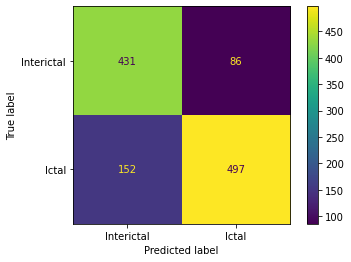

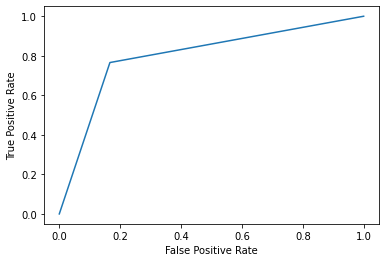

In [7]:
#ps = ParameterSearch()
#ps.results = p.results
#p = ps
p.summarize_all()

In [26]:
train = ChbDataset(mode='all',subject='chb10', welch_features=True, sampler='equal', multiclass=False,window_length=5)
ad = train.all_data()

['chb10/chb10_12.edf', 'chb10/chb10_20.edf', 'chb10/chb10_27.edf', 'chb10/chb10_30.edf', 'chb10/chb10_31.edf', 'chb10/chb10_38.edf', 'chb10/chb10_89.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 25 edf files


(174, 92)


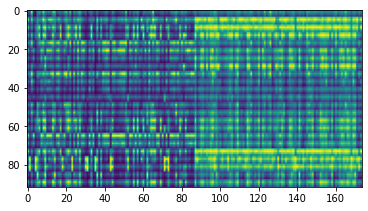

In [27]:
plt.imshow(ad[0].T)
print(ad[0].shape)

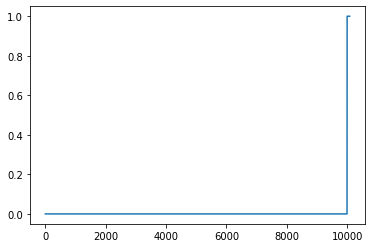

In [25]:
plt.plot(ad[1].T)

In [11]:
run = False
if run:
    x = ParameterSearch('XGBoostTrainer')
    x.search()

Training chb01
['chb01/chb01_21.edf', 'chb01/chb01_15.edf', 'chb01/chb01_03.edf', 'chb01/chb01_26.edf', 'chb01/chb01_16.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files
['chb01/chb01_18.edf', 'chb01/chb01_04.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 42 edf files


c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9565217391304348
Training chb02
['chb02/chb02_16.edf', 'chb02/chb02_16+.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 36 edf files
['chb02/chb02_19.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 23 channels
found 36 edf files
1.0
Training chb03
['chb03/chb03_35.edf', 'chb03/chb03_34.edf', 'chb03/chb03_36.edf', 'chb03/chb03_02.edf', 'chb03/chb03_04.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 

0.88
Training chb13
['chb13/chb13_55.edf', 'chb13/chb13_19.edf', 'chb13/chb13_59.edf', 'chb13/chb13_21.edf', 'chb13/chb13_62.edf', 'chb13/chb13_58.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'LUE-RAE', 'EKG1-EKG2', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8',

0.6666666666666666
Training chb19
['chb19/chb19_30.edf', 'chb19/chb19_28.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
found 50 channels
found 30 edf files
['chb19/chb19_29.edf']
sample rate: 256
channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', '-', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', '-', 'FZ-CZ', 'CZ-PZ', '-', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', '-', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', '-', 

Window length (s): 5
0.8782945187702037
False positives per day: 68.46329288795633
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       554
           1       0.90      0.86      0.88       612

    accuracy                           0.88      1166
   macro avg       0.88      0.88      0.88      1166
weighted avg       0.88      0.88      0.88      1166



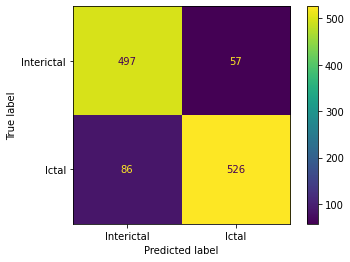

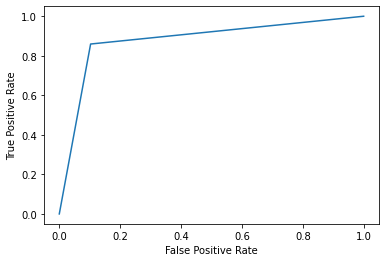

In [12]:
#xx = ParameterSearch()
#xx.results = x.results
#x = xx
x.summarize_all()